In [163]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from GridWorld_v1 import GridWorld_v1

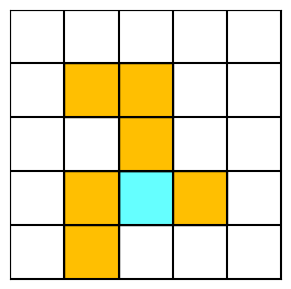

In [164]:
desc = rows = 5  # 记得行数和列数这里要同步改
columns = 5
desc = [".....",".##..","..#..",".#T#.",".#..."]

gridworld = GridWorld_v1(forbidden_area_score=-1, score=1,desc=desc) 
print(gridworld.animator.fig.get_facecolor())
gridworld.show()

In [165]:
class PolicyNet(torch.nn.Module):
    """只有一层隐藏层的Q网络"""

    def __init__(self,state_dim,action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, 64)
        self.fc2 = torch.nn.Linear(64, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        x = F.relu(self.fc2(x))
        return F.softmax(x,dim=1)  # 输出层不使用激活函数

In [166]:
class REINFORCE:
    def __init__(
        self,
        state_dim,
        action_dim,
        learning_rate,
        gamma,
        device,
    ) -> None:
        self.action_dim = action_dim
        self.policy_net = PolicyNet(state_dim, action_dim).to(device)

        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1000, gamma=0.9)
        self.device = device
        self.gamma = gamma

    def take_action(self, state:tuple[ int,int ]):
        # print(f"{state = }")
        # print(self.policy_net(torch.tensor( state , dtype=torch.float32).to(self.device)))
        state = torch.tensor([ state ], dtype=torch.float32).to(self.device)
        probs = self.policy_net(state)
        # print(f"{probs.shape=}")
        # print(f"{probs}")
        action_dist = torch.distributions.Categorical(probs)
        # print(action_dist)
        action = action_dist.sample()
        return action.item()

    def update(self, transiton_dict):
        reward_list = transiton_dict["rewards"]
        state_list = transiton_dict["states"]
        action_list = transiton_dict["actions"]
        G = 0
        self.optimizer.zero_grad() # 在这里就清零了
        for i in reversed(range(len(reward_list))):
            state = torch.tensor([state_list[i]], dtype=torch.float32).to(self.device)
            # print(f"{state=}")
            action = torch.tensor(action_list[i]).view(-1,1).to(self.device)
            # print(f"{action=}")
            # print(f"{action.shape=}")
            action_pro = self.policy_net(state)
            # print(f"{action_pro.shape=}")
            log_prob = torch.log(action_pro.gather( 1,action ))
            G = self.gamma * G + reward_list[i]
            # print(f"{log_prob=}")
            loss = -log_prob * G
            loss.backward()
        self.optimizer.step()

    def save(self, path):
        torch.save(self.policy_net.state_dict(), path)

In [167]:
lr = 1e-4
num_episodes = 10000
hidden_dim = 12
gamma = 0.98
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
state_dim = 2
action_dim = 5

agent = REINFORCE(
    state_dim, action_dim, lr,gamma, device
)

In [168]:
agent.take_action((1,1))

2

In [169]:
max_v = -100
for i in range(num_episodes):
    state = gridworld.reset((0,0))
    done = False
    episode_reward = 0
    transiton_dict = {
                "states": [],
                "actions": [],
                "rewards": [],
                "next_states": [],
                "dones": [],
            }

    while not done:
        action = agent.take_action(state)
        next_state, reward, done = gridworld.step(state, action)
        transiton_dict["states"].append(state)
        transiton_dict["actions"].append(action)
        transiton_dict["next_states"].append(next_state)
        transiton_dict["rewards"].append(reward)
        transiton_dict["dones"].append(done)
        state = next_state
        episode_reward += reward

    agent.update(transiton_dict)
    if episode_reward >= max_v:
        agent.save("model.pth")
        max_v = episode_reward
    if i % 30 == 0:
        print(f"episode: {i}, value: {episode_reward}")

episode: 0, value: -10.0
episode: 30, value: -23.0
episode: 60, value: -7.0
episode: 90, value: -33.0
episode: 120, value: -3.0
episode: 150, value: -58.0
episode: 180, value: -40.0
episode: 210, value: -42.0
episode: 240, value: -9.0
episode: 270, value: -6.0
episode: 300, value: -12.0
episode: 330, value: -35.0
episode: 360, value: -18.0
episode: 390, value: -11.0
episode: 420, value: -13.0
episode: 450, value: -20.0
episode: 480, value: 0.0
episode: 510, value: -51.0
episode: 540, value: -36.0
episode: 570, value: -9.0
episode: 600, value: -17.0
episode: 630, value: -6.0
episode: 660, value: -10.0
episode: 690, value: -11.0
episode: 720, value: -30.0
episode: 750, value: -14.0
episode: 780, value: -10.0
episode: 810, value: -5.0
episode: 840, value: -12.0
episode: 870, value: -7.0
episode: 900, value: -12.0
episode: 930, value: -6.0
episode: 960, value: -2.0
episode: 990, value: -6.0
episode: 1020, value: -10.0
episode: 1050, value: -13.0
episode: 1080, value: -72.0
episode: 1110, v

torch.Size([25, 5])
[[[0.15332241 0.15332241 0.3844706  0.15332241 0.15556216]
  [0.14312604 0.14312604 0.38907006 0.14312604 0.18155184]
  [0.13116772 0.13116772 0.426185   0.13116772 0.18031184]
  [0.11012918 0.11012918 0.48886257 0.11012918 0.1807499 ]
  [0.08985325 0.08985325 0.5501461  0.08985325 0.18029414]]

 [[0.17700684 0.17700684 0.2919726  0.17700684 0.17700684]
  [0.16428666 0.16428666 0.33231923 0.16428666 0.17482086]
  [0.1495112  0.1495112  0.36811146 0.1495112  0.18335497]
  [0.12900217 0.12900217 0.4271137  0.12900217 0.18587978]
  [0.10736965 0.10736965 0.48905006 0.10736965 0.18884097]]

 [[0.1886522  0.1886522  0.2453912  0.1886522  0.1886522 ]
  [0.18553631 0.18553631 0.25785482 0.18553631 0.18553631]
  [0.16724914 0.16724914 0.31156036 0.16724914 0.1866922 ]
  [0.14959396 0.14959396 0.3580983  0.14959396 0.19311982]
  [0.12814504 0.12814504 0.4212876  0.12814504 0.19427729]]

 [[0.19719982 0.19719982 0.21120073 0.19719982 0.19719982]
  [0.19894943 0.19894943 0.204

/var/folders/j6/x5g6fdss0lx3bjtvj9_5cmwh0000gn/T/ipykernel_25527/1436956871.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_net.load_state_dict(torch.load("model.pt

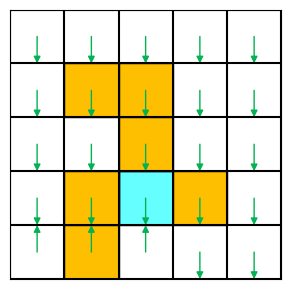

In [170]:
gridworld_idx = [(i, j) for i in range(rows) for j in range(columns)]
gridworld_idx =  torch.tensor(gridworld_idx,dtype=torch.float32)
best_net = PolicyNet(state_dim, action_dim).to(device)
best_net.load_state_dict(torch.load("model.pth"))
with torch.no_grad():
    q_tables =best_net(gridworld_idx)
    print(q_tables.shape)
    q_tables = np.array(q_tables).reshape(rows, columns, action_dim)
# print(f"q_tables_shape:{q_tables.shape}")
print(q_tables)
policy = np.argmax(q_tables, axis=2)
gridworld.show_policy(policy)